# Regression with LTN

This is a basic example in which we use LTN for training a regression estimator. The essence of regression is to approximate a function $f(x)=y$ where $y$ can be any real value or tensor (as opposed to classifiers which project values to $[0,1]$). We are given examples of this function $x_i$, $y_i$ with $f(x_i)=y_i$. From the examples, we need to estimate a function $f^\ast$ that approximates $f$.

In LTN we can directly model this by defining $f^\ast$ as a learnable/trainable function with some parameters that are constrained through data. Additionnally, we need a notion of $=$. Here, we use an euclidian distance/similarity to get a smooth $=$ function. We define the following language and theory:
- a set of points $x_i$ and $y_i$
- a definition of a predicate for equality, modeled as a smooth equality function $\mathrm{eq}(x,y)=\exp\bigg(-\sqrt{\sum_j (x_j-y_j)^2}\bigg)$
- a learnable function $f^\ast$ for which the following constraint hold: $\mathrm{eq}(f^\ast(x_i),y_i)$. The function $f^\ast$ approximates $f(x_i)=y_i$

Here, $f^\ast$ is modeled using a simple MLP.

In [1]:
import logging; logging.basicConfig(level=logging.INFO)
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import ltn
import pandas as pd

Init Plugin
Init Graph Optimizer
Init Kernel


# Data

Load the [real estate dataset](https://www.kaggle.com/quantbruce/real-estate-price-prediction): 
- 414 samples,
- 6 float features: transaction date (converted to float, eg. `2012.917` is equivalent to december), house age, distance to station, # of convenience stores nearby, lat, long,
- y: house price per unit area

In [2]:
df = pd.read_csv("real-estate.csv")
df = df.sample(frac=1) #shuffle
df.head(5)

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
126,127,2013.083,38.6,804.68970,4,24.97838,121.53477,62.9
124,125,2012.917,9.9,279.17260,7,24.97528,121.54541,57.4
264,265,2013.167,32.6,493.65700,7,24.96968,121.54522,40.6
403,404,2012.667,30.9,161.94200,9,24.98353,121.53966,39.7
192,193,2013.167,43.8,57.58945,7,24.96750,121.54069,42.7


We use 330 examples for training and 84 examples for testing.

In [3]:
x = df[['X1 transaction date', 'X2 house age',
       'X3 distance to the nearest MRT station',
       'X4 number of convenience stores', 'X5 latitude', 'X6 longitude']]
y = df[['Y house price of unit area']]

batch_size=128
ds_train = tf.data.Dataset.from_tensor_slices((x[:330],y[:330])).batch(batch_size)
ds_test = tf.data.Dataset.from_tensor_slices((x[330:],y[330:])).batch(batch_size)

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2021-08-30 20:50:47.010340: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-08-30 20:50:47.010472: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# LTN

In [4]:
f = ltn.Function.MLP(input_shapes=[6],output_shape=[1],hidden_layer_sizes=(8,8))

In [5]:
eq = ltn.Predicate.Lambda(
    #lambda args: tf.exp(-0.05*tf.sqrt(tf.reduce_sum(tf.square(args[0]-args[1]),axis=1)))        
    lambda args: 1/(1+0.5*tf.sqrt(tf.reduce_sum(tf.square(args[0]-args[1]),axis=1)))
)


In [6]:
Not = ltn.Wrapper_Connective(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(ltn.fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(p=2),semantics="forall")
Exists = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMean(p=2),semantics="exists")

In [7]:
@tf.function
def axioms(x_data, y_data):
    x = ltn.Variable("x", x_data)
    y = ltn.Variable("y", y_data)
    return Forall(ltn.diag(x,y), eq([f(x),y])).tensor

Initialize all layers and the static graph.



In [8]:
for x, y in ds_test:
    print("Initial sat level %.5f"%axioms(x,y))
    break

Initial sat level 0.00000


2021-08-30 20:51:03.047078: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-30 20:51:03.047576: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-08-30 20:51:03.047617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


# Training

Define the metrics. While training, we measure:
1. The level of satisfiability of the Knowledge Base of the training data.
2. The level of satisfiability of the Knowledge Base of the test data.
3. The training accuracy.
4. The test accuracy.

In [9]:
metrics_dict = {
    'train_sat': tf.keras.metrics.Mean(name='train_sat'),
    'test_sat': tf.keras.metrics.Mean(name='test_sat'),
    'train_accuracy': tf.keras.metrics.RootMeanSquaredError(name="train_accuracy"),
    'test_accuracy': tf.keras.metrics.RootMeanSquaredError(name="test_accuracy")
}

Define the training and testing steps.

In [10]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
@tf.function
def train_step(x, y):
    # sat and update
    with tf.GradientTape() as tape:
        sat = axioms(x, y)
        loss = 1.-sat
    gradients = tape.gradient(loss, f.trainable_variables)
    optimizer.apply_gradients(zip(gradients, f.trainable_variables))
    sat = axioms(x, y)
    metrics_dict['train_sat'](sat)
    # accuracy
    metrics_dict['train_accuracy'](y,f.model(x))
    
@tf.function
def test_step(x, y):
    # sat
    sat = axioms(x, y)
    metrics_dict['test_sat'](sat)
    # accuracy
    metrics_dict['test_accuracy'](y,f.model(x))

Training

In [11]:
import commons

EPOCHS = 1000

commons.train(
    EPOCHS,
    metrics_dict,
    ds_train,
    ds_test,
    train_step,
    test_step,
    csv_path="regression_results.csv",
    track_metrics=50
)

2021-08-30 20:48:33.916652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-30 20:48:34.116221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-30 20:48:34.305572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 0, train_sat: 0.0000, test_sat: 0.0000, train_accuracy: 1024.0039, test_accuracy: 987.7926
Epoch 50, train_sat: 0.0000, test_sat: 0.0000, train_accuracy: 1024.0039, test_accuracy: 987.7926
Epoch 100, train_sat: 0.0000, test_sat: 0.0000, train_accuracy: 1024.0039, test_accuracy: 987.7926
Epoch 150, train_sat: 0.0000, test_sat: 0.0000, train_accuracy: 1024.0039, test_accuracy: 987.7926
Epoch 200, train_sat: 0.0000, test_sat: 0.0000, train_accuracy: 1024.0039, test_accuracy: 987.7926
Epoch 250, train_sat: 0.0000, test_sat: 0.0000, train_accuracy: 1024.0039, test_accuracy: 987.7926
Epoch 300, train_sat: 0.0000, test_sat: 0.0000, train_accuracy: 1024.0039, test_accuracy: 987.7926
Epoch 350, train_sat: 0.0000, test_sat: 0.0000, train_accuracy: 1024.0039, test_accuracy: 987.7926
Epoch 400, train_sat: 0.0000, test_sat: 0.0000, train_accuracy: 1024.0039, test_accuracy: 987.7926
Epoch 450, train_sat: 0.0000, test_sat: 0.0000, train_accuracy: 1024.0039, test_accuracy: 987.7926
Epoch 500, tr

In [12]:
import seaborn as sns
sns.set(font_scale=1.2)

/opt/homebrew/Caskroom/miniforge/base/envs/tf-py39/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/tf-py39/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


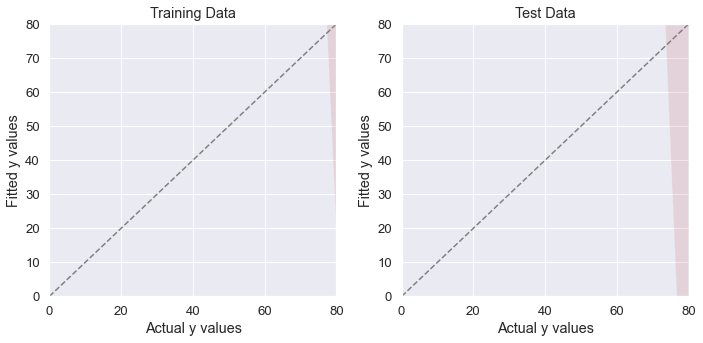

In [14]:


fig, axs = plt.subplots(1,2,figsize=(10,5))
ax = axs[0]
data = {'y_pred':[],'y_true':[]}
for x,y in ds_train:
    data['y_pred'].extend(f.model(x)[:,0].numpy())
    data['y_true'].extend(y[:,0].numpy())
df = pd.DataFrame(data,columns=['y_pred','y_true'])
ax.set_xlim(0,80)
ax.set_ylim(0,80)
sns.regplot("y_true","y_pred",data=df,ax=ax,truncate=False,
            scatter_kws={'alpha':0.5},line_kws={'color':'r','alpha':0.3,'linestyle':'--','linewidth':2})
ax.plot([0,100],[0,100],color="gray",linestyle="--")
ax.set_xlabel("Actual y values")
ax.set_ylabel("Fitted y values")
ax.set_title("Training Data")

ax = axs[1]
data = {'y_pred':[],'y_true':[]}
for x,y in ds_test:
    data['y_pred'].extend(f.model(x)[:,0].numpy())
    data['y_true'].extend(y[:,0].numpy())
df = pd.DataFrame(data,columns=['y_pred','y_true'])
ax.set_ylim(0,80)
ax.set_xlim(0,80)
sns.regplot("y_true","y_pred",data=df,ax=ax,truncate=False,
            scatter_kws={'alpha':0.5},line_kws={'color':'r','alpha':0.3,'linestyle':'--','linewidth':2})
ax.plot([0,100],[0,100],color="gray",linestyle="--")
ax.set_xlabel("Actual y values")
ax.set_ylabel("Fitted y values")
ax.set_title("Test Data")
plt.tight_layout()
#plt.savefig("ex_regression.pdf")